<a href="https://colab.research.google.com/github/YenLinWu/TensorFlow2_DeepDream/blob/master/TensorFlow2_%E5%AF%A6%E4%BD%9C_DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DeepDream** 是什麼？  

DeepDream 是一種使用卷積神經網絡( CNN )創造電腦影像視覺的技術，它是在 2015 年的夏季由 Google 所發表，主要是以深度學習資料庫 [Caffe](http://caffe.berkeleyvision.org/) 實作而成，由於 Deepdream 生成的圖片具有如幻覺般的奇特效果，因此而吸引眾人的目光。

---  
![minipic](https://upload.wikimedia.org/wikipedia/commons/6/65/Aurelia-aurita-3-0049.jpg)
Resourse : [WiKipedia](https://en.wikipedia.org/wiki/DeepDream)

---      
<br>    
DeepDream 與卷積神經網絡的運作原理非常相似，DeepDream 藉由過濾器( Filter )抓取原始圖片中的特徵，並對卷積神經網絡進行**梯度上升( Gradient Ascent )**，以啟動卷積神經網絡上層( Upper Layer )的特定過濾器，來進行圖片的生成，而它與卷積神經網絡的差異在於：  
* DeepDream 嘗試將所有過濾器的激活函數值最大化，而非特定的過濾器激活函數值；  
* 透過對原始圖片進行縮放，產生不同比例的尺寸( **八度 Octaves** )，進而提升視覺化的質量。   

現在，就讓我們嘗試用 DeepDream 創作出如幻覺般的圖片吧！！  
      


# DeepDream 實作   

本篇文章將使用 Google 免費提供的雲端開發環境 Colab ，在此環境中透過 Google Brain 的開源軟體 [TensorFlow 2.](https://www.tensorflow.org) 及開發工具 Keras 編輯程式碼。實際上，因 Keras 提供許多已預先訓練完成的卷積神經網絡模型，如：VGG、ResNet50 等，方便我們可選擇任一個模型來實作 DeepDream ，產生出來的圖片效果，會隨著模型架構的不同而不同。本篇文章我們將選用已預先訓練完成的 Inception V3 模型來實作 DeepDream 。 

# Step 1 : 匯入套件   



In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try :
  %tensorflow_version 2.x
except Exception :
  pass
import tensorflow as tf
from tensorflow.keras.preprocessing import image  # Keras 對圖片進行預處理

import numpy as np
import PIL.Image
import matplotlib as mpl
import IPython.display as display
from IPython.display import clear_output
from matplotlib import pyplot as plt  

# 查詢 Google Colab 提供我們的運算資源
!/opt/bin/nvidia-smi

TensorFlow 2.x selected.
Wed Mar  4 06:40:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                   

# Step 2 : 讀取原始圖片   

本文所使用的圖片來源 : [Labrador Retriever](https://commons.wikimedia.org/wiki/Labrador_Retriever)

## (2.0) 連結 Google Drive ( if necessary )  

因本篇文章的範例程式碼，將在 Google Colab 雲端開發環境中編輯與執行，故連上 Google Drive 以方便我們讀取或儲存圖片。若讀者使用自己的本機實作下列範例程式碼，則可省略此步驟。

In [0]:
from google.colab import drive
drive.mount( '/content/gdrive' )

在 Google Drive 中，我們可指定工作資料夾，並在其中新增 Pictures 資料夾，來存放原始圖片。

In [0]:
import os
print( f'預設的工作資料夾：{os.getcwd()}' )

# 指定 Google Drive 中的工作資料夾
os.chdir( '/content/gdrive/My Drive/Deep_Dream/' )
retval = os.getcwd()
print( f'指定的工作資料夾：{retval}' )

!mkdir -p Pictures  # 新增 Pictures 資料夾在工作資料夾中

預設的工作資料夾：/content
指定的工作資料夾：/content/gdrive/My Drive/Deep_Dream


## (2.1) 讀取原始圖片

In [0]:
# 定義函數：載入原始圖片
def Preprocess_Image( image_path, target_size=None ):
  img = tf.keras.preprocessing.image.load_img( image_path, target_size )   # PIL Format
  return img

# 定義函數：顯示原始圖片
def Show( img ):
  plt.figure( figsize=(12,12) )
  plt.imshow( img )
  plt.grid( False )
  plt.axis( 'off' )
  plt.show()

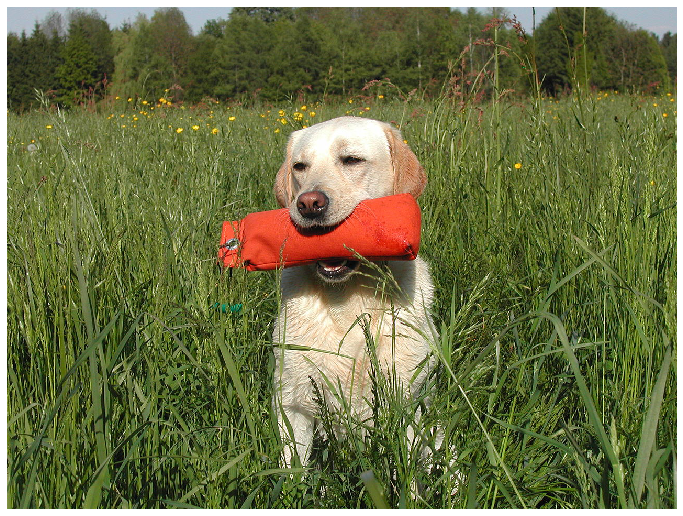

In [0]:
# 圖片的名稱及路徑
Image_Name = 'dog.jpg'
Image_Path = retval + '/Pictures/' + Image_Name 

# 載入圖片( 成 PIL 格式 )
Original_Image = Preprocess_Image( Image_Path )

# 顯示圖片
Show( Original_Image )

# Step 3 : 載入 Inception V3 模型

## (3.1) 載入模型   

使用 `tf.keras.applications.InceptionV3( )` 載入 Inception V3 模型，其中，參數 `weights='imagenet'` 表示此模型的權重已預先訓練完成，參數 `include_top=False` 表示載入的 Inception V3 模型並**不包含**最終的**全連接層( Fully Connected Layer )**。

In [0]:
# 載入預先訓練完成的 Inception V3 模型
Inception_V3 = tf.keras.applications.InceptionV3( weights='imagenet', include_top=False )

# 檢視 Inception V3 模型的結構
#model.summary()

87916544/87910968 [==============================] - 3s 0us/step


## (3.2) 選用隱藏層( Hidden Layer )   

在卷積神經網絡中，起初的隱藏層用於辨識圖片的局部細節，例如：邊邊角角的輪廓特徵，而較高的隱藏層則會辨識圖片中的物件特徵，例如：眼睛、鼻子、嘴巴等。因此，當我們選用較低的隱藏層時， DeepDream 生成的圖片會產生幾何圖案，若選用較高的隱藏層時，則會產生我們能辨識出的視覺圖案。 

In [0]:
# 選擇 Inception V3 的隱藏層( Hidden Layer )
Names = [ 'mixed2', 'mixed3', 'mixed6' ]
Layers = [ Inception_V3.get_layer(name).output for name in Names ]

# 選定隱藏層所擷取出的模型
Dream_Model = tf.keras.Model( inputs=Inception_V3.input, outputs=Layers )

# Step 4 : 損失函數( Loss Function )   

 

In [0]:
# 定義損失函數 
def Loss_Function( img, model ):
  # 新增批量維度( Batch Dimension )代表圖片的張數
  img_batch = tf.expand_dims( img, axis=0 )   # tf.Tensor 格式 
  
  layer_activations = model( img_batch )
  if len( layer_activations ) == 1:
    layer_activations = [ layer_activation ]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean( act )
    losses.append( loss )

  return  tf.reduce_sum( losses )

# Step 5 : 梯度上升( Gradient Ascent )   

In [0]:
# 建立梯度上升演算法 
class Gradient_Ascent( tf.Module ):   # 建立模組
  def __init__( self, model ):        # 物件初始化
    self.model = model
  
  @tf.function(
      # 定義輸入的張量條件
      input_signature = (
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32), 
        ) )
  
  def __call__( self, img, iterations, step_size ):
      '''
      iterations : 執行梯度上升的次數
      step_size : 每次執行梯度上升的變化量
      '''
      loss = tf.constant( 0.0 )   # 損失函數初始化
      for i in tf.range( iterations ) :
        with tf.GradientTape() as tape:
          tape.watch( img )
          loss = Loss_Function( img, self.model )

        # 計算損失函數的梯度及其梯度正規化( Normalization )
        gradients = tape.gradient( loss, img )
        gradients /= tf.math.reduce_std( gradients ) + 1e-8 
        
        print( '...Loss value at', i, ': ', loss )
        # print( '...grad value at', i, ': ', gradients )  # 梯度將逐漸趨近於 0 
        img = img + step_size*gradients     # 將圖片與梯度進行相加
        img = tf.clip_by_value( img, -1, 1 )
    
      return loss, img

In [0]:
GradientAscent = Gradient_Ascent( Dream_Model )

# Step 6 : 八度( Octave )   

一般而言，若我們直接採用原始圖片來生成 DeepDream 圖片時，容易產生演算法的收斂較慢、圖片解析度( Resolution )變差等問題，因此，在 DeepDream 演算法中，最後會再定義一個對圖片比例進行縮放的步驟，稱之為**八度( Octave )**，換句話說，我們會先縮小原始圖片的尺寸，再進行梯度上升，而每一次梯度上升所生成的圖片，將會以某固定比例放大，再接續進行下一次的梯度上升。

In [0]:
# PIL 格式 -> Array -> tf.Tensor 格式
img = tf.constant( np.array(Original_Image) )  

# 取得原始圖片的尺寸(寬*高)
Original_Shape = tf.shape( img )[ :-1 ]  

# 原始圖片尺寸的資料型態轉為浮點數型態
Float_Original_Shape = tf.cast( Original_Shape, tf.float32 )   
print( '原始圖片的尺寸 : ', Float_Original_Shape, '\n' )

''' 八度 '''
Num_Octave = 4       # 不同比例尺寸的數量(包含原始圖片的尺寸)
Octave_Scale = 1.4   # 不同比例尺寸圖片的縮放大小

Shapes_List = [ Original_Shape ]   # 儲存不同比例的尺寸(寬*高)    
for n in range( 1, Num_Octave ):  
  New_Shape = tf.cast( Float_Original_Shape/(Octave_Scale**n), tf.int32 ) 
  Shapes_List.append( New_Shape )  
Shapes_List = Shapes_List[ ::-1 ]   # 不同比例的圖片尺寸從小到大排序

print( '不同比例的尺寸 : ' )
Shapes_List

原始圖片的尺寸 :  tf.Tensor([ 960. 1280.], shape=(2,), dtype=float32) 

不同比例的尺寸 : 


[<tf.Tensor: shape=(2,), dtype=int32, numpy=array([349, 466], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([489, 653], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([685, 914], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 960, 1280], dtype=int32)>]

# Step 7 : DeepDream 生成圖片

In [0]:
# 定義函數：將 Inception V3 模型的產出轉成圖片格式
def Deprocess( img ):
  img = 255*(img + 1.0)/2.0
  return tf.cast( img, tf.uint8 )

In [0]:
# 定義每次執行梯度上升演算法的流程
def DeepDream( img, iterations=50, step_size=0.01 ): 
  '''
  iterations：執行梯度上升的次數
  step_size : 每次執行梯度上升的變化量
  '''
  # tf.Tensor 格式
  step_size = tf.convert_to_tensor( step_size )   # dtype = float32
  
  # 將圖片預處理成 Inception V3 模型可處理的張量(Tensor)
  img = tf.keras.applications.inception_v3.preprocess_input( img )
  img = tf.convert_to_tensor( img )

  iterations_remaining = iterations
  iteration = 0
  while iterations_remaining:
    if iterations_remaining > 50:
      run_iterations = tf.constant( 50 )
    else:
      run_iterations = tf.constant( iterations_remaining )
    iterations_remaining -= run_iterations
    iteration += run_iterations

    # 執行梯度上升演算法
    loss, img = GradientAscent( img, run_iterations, tf.constant( step_size ) )
    
    if run_iterations % 10 == 0:
      clear_output( wait=True )
      Show( Deprocess(img) )
      print( 'Iterations {}, Loss {}'.format( run_iterations, loss ) )
  
  # 將 Inception V3 模型結果轉回圖片格式後顯示圖片
  result = Deprocess( img )
  clear_output( wait=True )
  Show( result )

  return result

將原始圖片的尺寸縮小，運行 DeepDream 演算法來生成圖片 :  

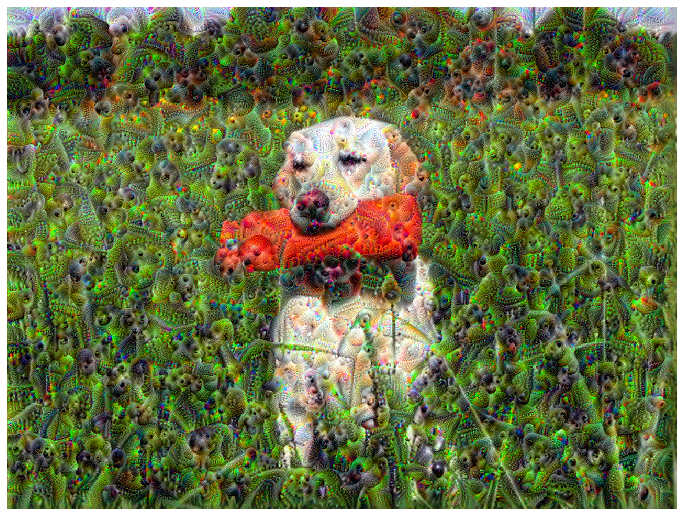

In [0]:
for new_shape in Shapes_List:     
  print( 'Processing image shape', new_shape )
  # 縮放圖片的尺寸
  img = tf.image.resize( img, new_shape ).numpy()
  
  # 執行 DeepDream 演算法
  img = DeepDream( img, iterations=50, step_size=0.01 )

display.clear_output( wait=True )
Dream_Image = tf.image.resize( img, Original_Shape )
Dream_Image = tf.image.convert_image_dtype( Dream_Image/255.0, dtype=tf.uint8 )
Show( Dream_Image )

## 儲存 DeepDream 圖片

In [0]:
# 儲存路徑 = Google Drive 資料夾路徑 + 圖片名稱
Path = retval + '/DeepDream_' + Image_Name

# 儲存 DeepDream 圖片
tf.keras.preprocessing.image.save_img( path=Path, x=Dream_Image.numpy(), file_format='png' )

# 結語

本文透過 TensorFlow 2. 來實作 DeepDream 圖片生成，讀者們不訪也可選用不同的隱藏層、調整八度縮放的比例、調整梯度上升的變化量，甚至使用其他的模型等，來嘗試產生不同的 DeepDream 圖片。   
有關本文的內容，若讀者們有發現任何的錯誤或疑問，非常歡迎您[來信( yenlinwu1112@gmail.com )]( mailto:yenlinwu1112@gmail.com )給予建議及討論，讓我們一同學習成長！

# 參考資料     

*   DeepDream [https://en.wikipedia.org/wiki/DeepDream](https://en.wikipedia.org/wiki/DeepDream)  
*   DeepDream Tutorials [https://www.tensorflow.org/tutorials/generative/deepdream](https://www.tensorflow.org/tutorials/generative/deepdream)